## Task 3: Customer Segmentation / Clustering

**Objective:**
We will perform customer segmentation using KMeans clustering on the customer data based on their purchasing behavior and signup recency. We will also use the Elbow Method to determine the optimal number of clusters.

## Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [2]:
customers=pd.read_csv(r"C:\Users\Gunolla Srinivas\Downloads\Customers.csv")
transactions=pd.read_csv(r"C:\Users\Gunolla Srinivas\Downloads\Transactions.csv")

In [3]:
# Inspect datasets
print("Customers:")
print(customers.head())
print("Transactions:")
print(transactions.head())

Customers:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
Transactions:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


## Data preprocessing

In [4]:
# Merge datasets
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

# Aggregate transaction data for each customer
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',        # Total spending
    'TransactionID': 'count',   # Purchase frequency
}).reset_index()

merged_data = customers.merge(customer_transactions, on='CustomerID', how='left')
print("Merged Data:")
print(merged_data.head())

Merged Data:
  CustomerID        CustomerName         Region SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America 2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia 2022-02-13     1862.74   
2      C0003      Michael Rivera  South America 2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America 2022-10-09     5354.88   
4      C0005         Laura Weber           Asia 2022-08-15     2034.24   

   TransactionID  
0            5.0  
1            4.0  
2            4.0  
3            8.0  
4            3.0  


In [5]:
merged_data.isnull().sum()

CustomerID       0
CustomerName     0
Region           0
SignupDate       0
TotalValue       1
TransactionID    1
dtype: int64

In [6]:
merged_data.dropna(inplace=True)
merged_data.isnull().sum()

CustomerID       0
CustomerName     0
Region           0
SignupDate       0
TotalValue       0
TransactionID    0
dtype: int64

## Feature engineering

In [7]:

merged_data['Recency'] = (pd.Timestamp.now() - merged_data['SignupDate']).dt.days  # Days since signup

# Select relevant features for clustering
clustering_data = merged_data[['TotalValue',  'Recency']]

print("Clustering Data:")
print(clustering_data.head())


Clustering Data:
   TotalValue  Recency
0     3354.52      929
1     1862.74     1076
2     2725.38      323
3     5354.88      838
4     2034.24      893


## Standardize the data

In [8]:

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

print("Scaled Data:")
print(scaled_data[:5])  


Scaled Data:
[[-0.06170143  1.148752  ]
 [-0.87774353  1.60043068]
 [-0.40585722 -0.71327032]
 [ 1.03254704  0.86914138]
 [-0.78392861  1.03813681]]


## Elbow Method to determine the optimal number of clusters

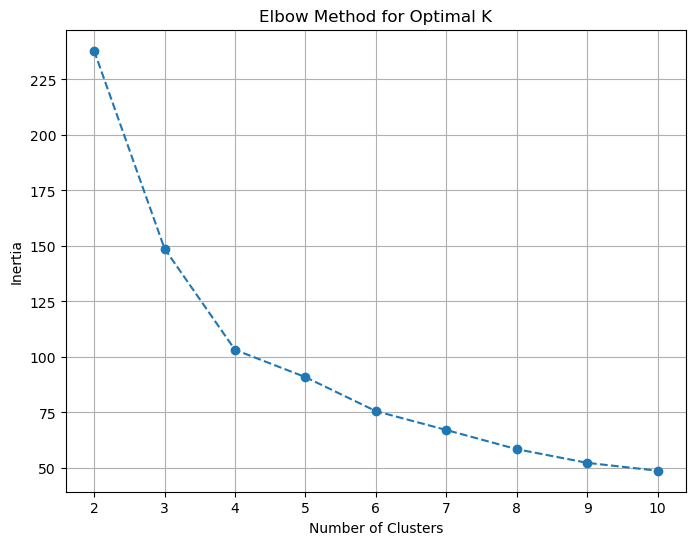

In [9]:

inertia = []
k_range = range(2, 11)  # Test cluster numbers from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


## Fit KMeans with the Optimal Number of Clusters

In [10]:
# 4 is the  optimal number of clusters based on the evaluation
optimal_k = 4

# Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(scaled_data)
merged_data['Cluster'] = kmeans.labels_

print("Clustered Data:")
print(merged_data[['CustomerID', 'Cluster']].head())


Clustered Data:
  CustomerID  Cluster
0      C0001        1
1      C0002        1
2      C0003        0
3      C0004        3
4      C0005        1


## visualise the clusters

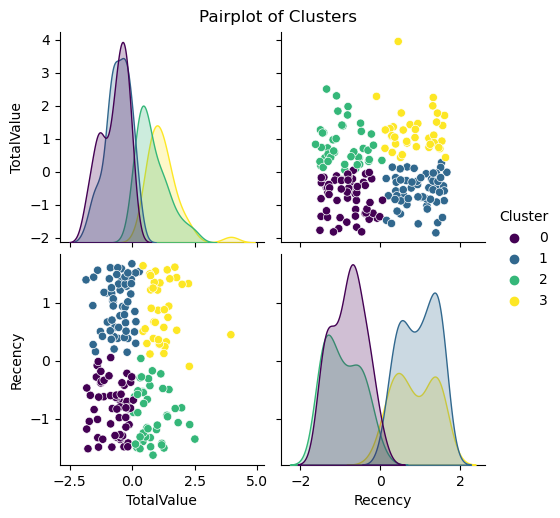

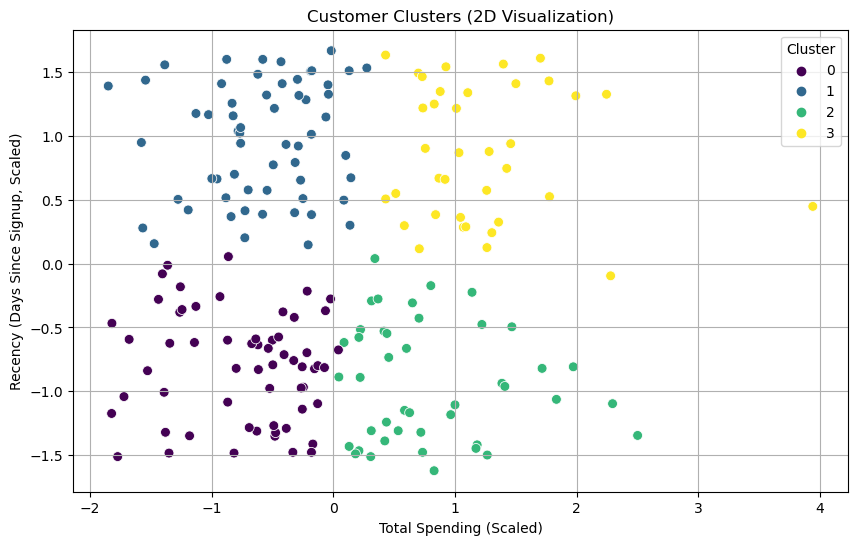

In [11]:
# Add cluster labels to the data
clustered_data = pd.DataFrame(scaled_data, columns=['TotalValue', 'Recency'])
clustered_data['Cluster'] = kmeans.labels_

# Pairplot for visualization
sns.pairplot(clustered_data, hue='Cluster', palette='viridis')
plt.suptitle("Pairplot of Clusters", y=1.02)
plt.show()

# 2D Scatter plot for clarity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_data, x='TotalValue', y='Recency', hue='Cluster', palette='viridis', s=50)
plt.title('Customer Clusters (2D Visualization)')
plt.xlabel('Total Spending (Scaled)')
plt.ylabel('Recency (Days Since Signup, Scaled)')
plt.legend(title='Cluster')
plt.grid()
plt.show()


## cluster performance

In [12]:
# Final metrics for the optimal number of clusters
final_db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
final_silhouette_score = silhouette_score(scaled_data, kmeans.labels_)

print(f"Final DB Index: {final_db_index:.2f}")
print(f"Final Silhouette Score: {final_silhouette_score:.2f}")


Final DB Index: 0.79
Final Silhouette Score: 0.42


## Summary of the findings

**Cluster 0 (Purple):**
Customers with low spending and higher recency values (less recent signups).
Likely represents customers who signed up long ago and don't spend much.
Insight: Consider re-engaging these customers with promotions or personalized offers.

**Cluster 1 (Blue):**
Customers with moderate recency (fairly recent signups) but low spending.
These might be relatively new customers still exploring the service.
Insight: Target them with upselling or onboarding strategies to increase spending.

**Cluster 2 (Green):**
Customers with moderate recency and moderate spending.
Represents active customers with decent engagement.
Insight: Encourage loyalty programs or cross-selling opportunities to retain and boost spending.

**Cluster 3 (Yellow):**
Customers with high spending and low recency values (very recent signups).
Likely new, high-value customers.
Insight: Focus on retaining these customers by offering excellent service or exclusive benefits to build long-term loyalty.